Setup & Upload Training File

In [3]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Automatically get the uploaded filename
zip_filename = next(iter(uploaded))

# Extract the zip file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content")  # Extract into /content

# Assuming the extracted folder is named 'training'
BASE_DIR = "/content/training/datasets_split"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

print("✅ Extracted and paths are set:")
print(f"TRAIN_DIR = {TRAIN_DIR}")
print(f"VAL_DIR = {VAL_DIR}")
print(f"TEST_DIR = {TEST_DIR}")


import os

# Check for overlapping files
if os.path.exists(TEST_DIR):
    train_files = set(os.listdir(TRAIN_DIR))
    test_files = set(os.listdir(TEST_DIR))
    overlap = train_files.intersection(test_files)
    print(f"⚠️ Overlapping files between train and test: {len(overlap)}")
else:
    print("⚠️ TEST_DIR does not exist, skipping overlap check.")

Saving training.zip to training (1).zip
✅ Extracted and paths are set:
TRAIN_DIR = /content/training/datasets_split/train
VAL_DIR = /content/training/datasets_split/val
TEST_DIR = /content/training/datasets_split/test
⚠️ Overlapping files between train and test: 12


Cleanup & Fix Overlap Files

In [4]:
import os
import shutil

def list_all_images(root_dir):
    return set([
        os.path.relpath(os.path.join(root, file), start=root_dir)
        for root, _, files in os.walk(root_dir)
        for file in files if file.lower().endswith((".jpg", ".png", ".jpeg"))
    ])

train_images = list_all_images(TRAIN_DIR)
test_images = list_all_images(TEST_DIR)
overlap = train_images.intersection(test_images)

print(f"🧼 Removing {len(overlap)} overlapping images from TEST_DIR...")

for relative_path in overlap:
    test_file_path = os.path.join(TEST_DIR, relative_path)
    if os.path.exists(test_file_path):
        os.remove(test_file_path)

print("✅ Done cleaning test set.")
import os

def list_all_images(root_dir):
    return set([
        os.path.relpath(os.path.join(root, file), start=root_dir)
        for root, _, files in os.walk(root_dir)
        for file in files if file.lower().endswith((".jpg", ".png", ".jpeg"))
    ])

train_images = list_all_images(TRAIN_DIR)
test_images = list_all_images(TEST_DIR)
overlap = train_images.intersection(test_images)

print(f"🔁 Rechecking for overlaps...")
print(f"⚠️ Overlapping files between train and test: {len(overlap)}")
if len(overlap) > 0:
    print("❗ Sample overlapping files:")
    for i, path in enumerate(list(overlap)[:5]):
        print(f"  - {path}")


🧼 Removing 1088 overlapping images from TEST_DIR...
✅ Done cleaning test set.
🔁 Rechecking for overlaps...
⚠️ Overlapping files between train and test: 0


Train and Test ResNet34 Model

✅ Test set recreated safely.
[Epoch 1] Loss: 179.0634 | Train Acc: 47.27% | Val Acc: 59.49%
📌 New best model saved with val acc: 59.49%
[Epoch 2] Loss: 147.6442 | Train Acc: 57.24% | Val Acc: 69.91%
📌 New best model saved with val acc: 69.91%
[Epoch 3] Loss: 128.7517 | Train Acc: 63.38% | Val Acc: 69.87%
[Epoch 4] Loss: 122.7329 | Train Acc: 64.70% | Val Acc: 74.68%
📌 New best model saved with val acc: 74.68%
[Epoch 5] Loss: 115.8816 | Train Acc: 66.32% | Val Acc: 77.28%
📌 New best model saved with val acc: 77.28%
[Epoch 6] Loss: 91.4023 | Train Acc: 74.32% | Val Acc: 85.83%
📌 New best model saved with val acc: 85.83%
[Epoch 7] Loss: 77.3043 | Train Acc: 77.44% | Val Acc: 87.74%
📌 New best model saved with val acc: 87.74%
[Epoch 8] Loss: 69.5721 | Train Acc: 80.29% | Val Acc: 88.15%
📌 New best model saved with val acc: 88.15%
[Epoch 9] Loss: 66.2542 | Train Acc: 80.49% | Val Acc: 89.21%
📌 New best model saved with val acc: 89.21%
[Epoch 10] Loss: 62.0371 | Train Acc: 81.89% | Val Acc: 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


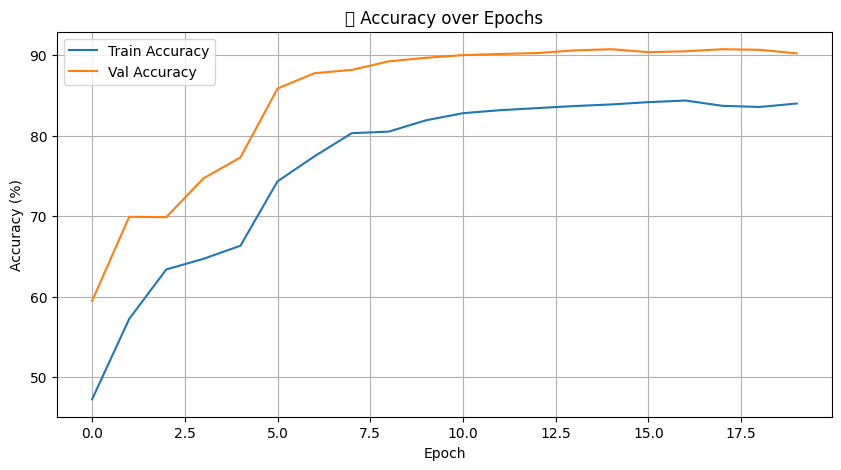

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


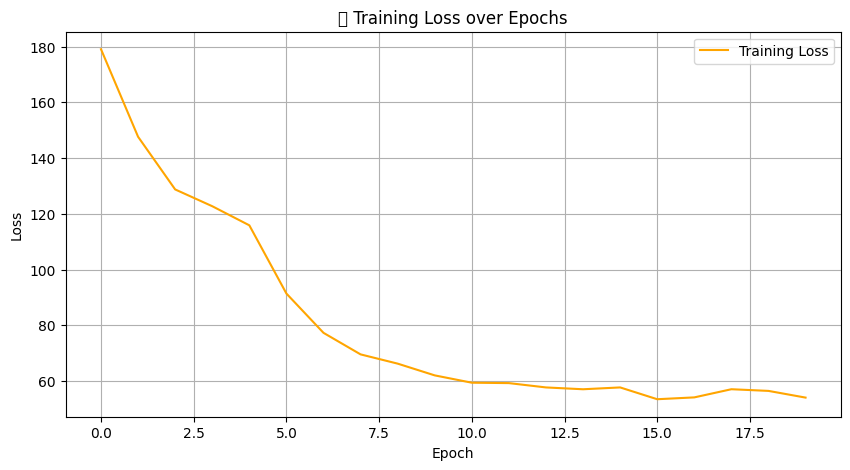

In [ ]:
import os
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader


def create_clean_test_set(train_dir, test_dir, test_ratio=0.2):
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)
    os.makedirs(test_dir)

    for class_name in os.listdir(train_dir):
        class_train_dir = os.path.join(train_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)

        if not os.path.isdir(class_train_dir):
            continue

        os.makedirs(class_test_dir, exist_ok=True)

        # Get list of images and shuffle
        images = os.listdir(class_train_dir)
        random.shuffle(images)

        # Move 20% of images to test
        num_test = int(len(images) * test_ratio)
        for img_name in images[:num_test]:
            src = os.path.join(class_train_dir, img_name)
            dst = os.path.join(class_test_dir, img_name)
            shutil.move(src, dst)

    print("✅ Test set recreated safely.")
create_clean_test_set(TRAIN_DIR, TEST_DIR)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),  # Better than just Resize
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add this
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Add this
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets and Loaders
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=eval_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load and configure model
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Add dropout here
    nn.Linear(512, len(train_dataset.classes))
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


best_val_acc = 0.0

# Training loop
epochs = 20
train_acc_list = []
val_acc_list = []
loss_list = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    scheduler.step()

    model.eval()
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)
    loss_list.append(running_loss)

    print(f"[Epoch {epoch+1}] Loss: {running_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "/content/resnet34_best.pth")
        print(f"📌 New best model saved with val acc: {best_val_acc:.2f}%")


model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {test_accuracy:.2f}%")

model.load_state_dict(torch.load("/content/resnet34_best.pth"))
model.to(device)

import os

save_dir = "/content/drive/MyDrive/pest_classification"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "resnet34_pest_model_best.pth")

torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to: {save_path}")


from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Print report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.title("📈 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Training Loss', color='orange')
plt.title("📉 Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
